----
# EDA and Modelling Part-1
----

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Loading the dataset

In [2]:
jobs = pd.read_csv('job_postings.3.csv')

#### Checking the shape and the first two rows

In [3]:
jobs.shape

(875, 10)

In [4]:
jobs.head(2)

,Unnamed: 0,job_area,job_classification,job_company,job_description,job_location,job_type,job_title,job_salary,salary_cat
0,0,CBD and Inner Suburbs,Science and Technology,SEEK Limited,The Opportunity We're looking for an experienc...,Melbourne,Full Time,senior data scientist,150000.0,high
1,1,Parramatta and Western Suburbs,Information and Communication Technology,ecareer employment services,Put Data to best useDesign & Develop BI Soluti...,Sydney,Full Time,senior data scientist,135000.0,high


#### Removing the unnecessary columns 

In [5]:
jobs= jobs.drop(['Unnamed: 0'],axis=1)

#### Removing duplicates if any

In [6]:
jobs.drop_duplicates(subset=['job_area', 'job_classification', 'job_company','job_description', 
                             'job_location', 'job_type', 'job_title','job_salary','salary_cat'], keep='first', inplace= True)

In [7]:
jobs.shape

(875, 9)

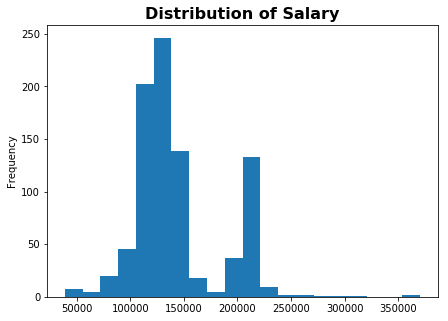

In [8]:
# Distribution is highly skewed
plt.figure(figsize=(7,5))
jobs['job_salary'].plot.hist(bins=20)
plt.title('Distribution of Salary',fontsize=16,fontweight='bold')
plt.show()

In [9]:
jobs['job_salary']=np.log(jobs['job_salary'])

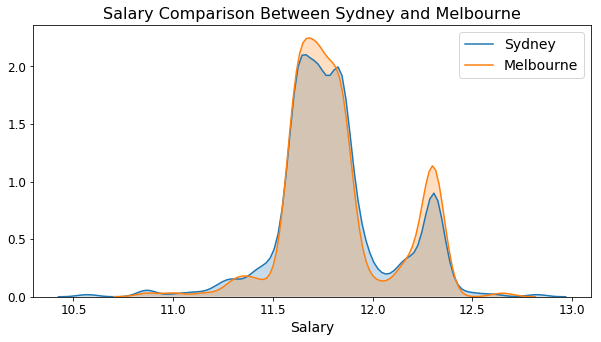

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for city in ['Sydney', 'Melbourne']:
    sns.kdeplot(jobs[jobs['job_location'].str.contains(city)]['job_salary'], shade=True, ax=ax, label=city)

plt.title('Salary Comparison Between Sydney and Melbourne', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

In [11]:
jobs1=jobs[["job_area","job_classification","job_location","job_type","job_title","job_salary"]]

In [12]:
jobs1.head()

,job_area,job_classification,job_location,job_type,job_title,job_salary
0,CBD and Inner Suburbs,Science and Technology,Melbourne,Full Time,senior data scientist,11.918391
1,Parramatta and Western Suburbs,Information and Communication Technology,Sydney,Full Time,senior data scientist,11.813030
2,Ryde and Macquarie Park,Information and Communication Technology,Sydney,Full Time,data scientist,11.849398
3,CBD and Inner Suburbs,Information and Communication Technology,Melbourne,Full Time,data scientist,11.849398
4,CBD and Inner Suburbs,Consulting and Strategy,Melbourne,Full Time,data scientist,11.849398


#### Correlation Matrix

In [13]:
%%time
# Define function for matrix for Cramer's V test
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramers_v_cross(df):
    columns = df.columns
    chi2_vals = dict()
    for col in columns:
        chi2_vals[col] = [cramers_v(df[col], df[column]) for column in df.columns]
    return pd.DataFrame(chi2_vals, index=columns, columns=columns)

cramers = cramers_v_cross(jobs1)

CPU times: user 415 ms, sys: 2.9 ms, total: 418 ms
Wall time: 417 ms


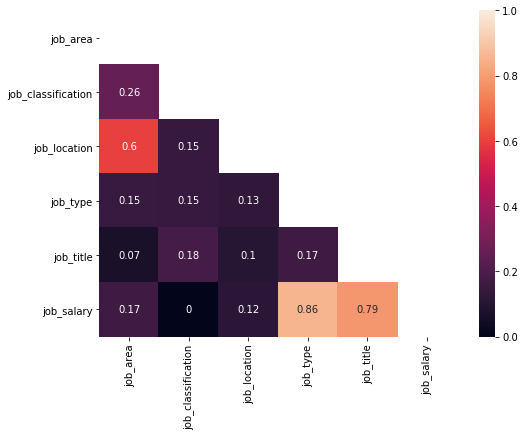

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

mask = np.zeros_like(cramers, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cramers, mask=mask, annot=True, fmt='.2g', vmin=0, vmax=1)
plt.show()

> ## Simple Linear Regression

In [15]:
# Defininf the X and Y variables
X = jobs1.drop('job_salary', axis=1)
y = jobs1['job_salary']

In [16]:
# Dummyfing the variables
X = pd.get_dummies(X,drop_first=True)

In [17]:
#Now do a train-test split, leaving 1/3rd of the data in the test set
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.33, random_state=42)

In [18]:
#Standardize the predictors
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [19]:
#Fit the training data to a linear regression
linreg = LinearRegression()
linreg.fit(Xs_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
# Predict Xs_test
preds=linreg.predict(Xs_test)

In [21]:
#Evaluate the model on test data
linreg.score(Xs_test,y_test)

-6.114704601773113e+23

### Applying Regularization : Ridge Regression

In [22]:
# with ridge regularization will find the optimal alpha value using CV
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print(optimal_ridge.alpha_)

68.26071834272389


In [23]:
#fit
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(Xs_train,y_train)

Ridge(alpha=68.26071834272389, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [24]:
# Predict Xs_test
pred= ridge.predict(Xs_test)

In [25]:
#Evaluate the model on test data
ridge_score=ridge.score(Xs_test,y_test)

Ridge regression does not improve the model significantly.

### Lasso Regression

In [26]:
# with lasso regularization will find the optimal alpha value using CV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.006194046459740219


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [27]:
#fit
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(Xs_train,y_train)

Lasso(alpha=0.006194046459740219, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
# Predict Xs_test
pred= lasso.predict(Xs_test)

In [29]:
#Evaluate the model on test data

lasso_score=lasso.score(Xs_test,y_test)

Lasso regression is not doing well either. Perhaps other approaches to feature elimination are needed.

#### Top 10 features contributing

In [30]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(10)

,variable,coef,abs_coef
43,job_title_data engineer,0.099135,0.099135
45,job_title_junior data analyst,-0.063457,0.063457
42,job_title_data analyst,-0.053585,0.053585
48,job_title_senior data scientist,0.034345,0.034345
6,job_area_None,0.029883,0.029883
46,job_title_junior data engineer,-0.024962,0.024962
22,job_classification_Education and Training,-0.022585,0.022585
41,job_type_Full Time,-0.018611,0.018611
7,job_area_North Shore and Northern Beaches,-0.016875,0.016875
44,job_title_data scientist,0.007761,0.007761


> ## Classification with Logistic Regression

Regression modelling led to some interesting observations, but I had some doubts about the efficacy of the model. Given the discontinuous distribution of the salary data, is it easier to predict salary if we define three categories: low, medium and high?

In [31]:
jobs2=jobs[["job_area","job_classification","job_location","job_type","job_title","salary_cat"]]

In [32]:
jobs2.head(2)

,job_area,job_classification,job_location,job_type,job_title,salary_cat
0,CBD and Inner Suburbs,Science and Technology,Melbourne,Full Time,senior data scientist,high
1,Parramatta and Western Suburbs,Information and Communication Technology,Sydney,Full Time,senior data scientist,high


In [33]:
def converter(val):
    if val == 'low':
        return 1
    if val == 'medium':
        return 2
    else:
        return 3         

In [34]:
jobs2['salary_cat'].value_counts()

high      433
medium    395
low        47
Name: salary_cat, dtype: int64

In [35]:
jobs2['salary_category']= jobs2['salary_cat'].map(lambda x: converter(x))

In [36]:
# baseline accuracy
jobs2['salary_category'].value_counts(normalize=True)

3    0.494857
2    0.451429
1    0.053714
Name: salary_category, dtype: float64

In [37]:
#Defining new X and y Varibales
X = jobs2.drop(['salary_category','salary_cat'], axis=1)
y = jobs2['salary_category']

In [38]:
X = pd.get_dummies(X,drop_first=True)

In [39]:
# train and test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.33, random_state=42)

In [40]:
#Standardize the predictors
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test= ss.transform(X_test)


In [41]:
# fit the model
logr= LogisticRegression(solver='newton-cg',class_weight= 'balanced')
logr.fit(Xs_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [42]:
pred= logr.predict(Xs_test)

In [43]:
logr.score(Xs_test,y_test)

0.7093425605536332

### Tuning the hyperparameters using Grid SearchCV

In [44]:
params ={"C":[0.0001,0.001,0.01,0.01,0.15,0.25,0.275,.05,.66,0.75,1.0,2.5,5.0,10.0,100.0,1000.0],
        "penalty":['l2']
        }

In [45]:
logreg_gs = GridSearchCV(LogisticRegression(solver='newton-cg',class_weight= 'balanced'),
                         params,cv=5, verbose=False)
logreg_gs.fit(Xs_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 0.15, 0.25, 0.275, 0.05, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [46]:
# Best Paramaters for C and penalty 
lr=logreg_gs.best_estimator_
print(logreg_gs.best_params_)

{'C': 0.0001, 'penalty': 'l2'}


In [47]:
lr_pred=lr.predict(Xs_test)
lr_score=lr.score(Xs_test,y_test)
print('model accuracy: ', lr.score(X_test, y_test))

model accuracy:  0.7508650519031141


In [48]:
# Classification report
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           1       0.62      0.25      0.36        20
           2       0.73      0.69      0.71       113
           3       0.78      0.87      0.82       156

   micro avg       0.76      0.76      0.76       289
   macro avg       0.71      0.60      0.63       289
weighted avg       0.75      0.76      0.75       289



In [49]:
def examine_coefficients(model, df):
    df = pd.DataFrame({ 'Coefficient' : lr.coef_[0] , 
                       'Feature' : df.columns}).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]

In [50]:
examine_coefficients(lr, X).head(10)

,Coefficient,Feature
44,-0.005907,job_title_data scientist
6,-0.005838,job_area_None
36,-0.003298,job_location_Adelaide
27,-0.002866,job_classification_Information and Communicati...
11,-0.002773,job_area_Parramatta and Western Suburbs
47,-0.002640,job_title_senior business intelligence
35,-0.002627,job_classification_Science and Technology
2,-0.002408,job_area_CBD Inner and Western Suburbs
21,-0.002312,job_classification_Consulting and Strategy
1,-0.002290,job_area_CBD Inner West and Eastern Suburbs


> ## Classification with Decison Trees

In [51]:
#Gridsearch again for hyperparameters
params = {'max_depth':[3,4,5,6,7],
         'max_leaf_nodes':[2,3,4,5],
         'min_samples_split':[2,4,5,8,10,15,25],
         'max_features':[5,10,14,17,23,30,35]}
dtc_gs = GridSearchCV(DecisionTreeClassifier(), params, cv=5)


In [52]:
dtc_gs.fit(Xs_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5, 6, 7], 'max_leaf_nodes': [2, 3, 4, 5], 'min_samples_split': [2, 4, 5, 8, 10, 15, 25], 'max_features': [5, 10, 14, 17, 23, 30, 35]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
dtc = dtc_gs.best_estimator_
print(dtc_gs.best_params_)

{'max_depth': 3, 'max_features': 30, 'max_leaf_nodes': 5, 'min_samples_split': 15}


In [54]:
dtc_pred = dtc.predict(Xs_test)
dtc_score = dtc.score(Xs_test, y_test)
print('model accuracy: ', dtc.score(Xs_test, y_test))


model accuracy:  0.7612456747404844


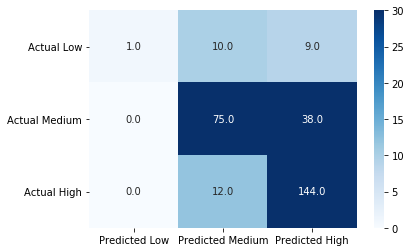

In [55]:
cm = confusion_matrix(y_test, dtc_pred)
sns.heatmap(cm, annot=True, fmt = '.1f', cmap = 'Blues', vmax = 30, vmin = 0, 
            xticklabels = ['Predicted Low','Predicted Medium','Predicted High'], 
            yticklabels = ['Actual Low', 'Actual Medium', 'Actual High'])

In [56]:
# Classification report
print(classification_report(y_test,dtc_pred))

              precision    recall  f1-score   support

           1       1.00      0.05      0.10        20
           2       0.77      0.66      0.71       113
           3       0.75      0.92      0.83       156

   micro avg       0.76      0.76      0.76       289
   macro avg       0.84      0.55      0.55       289
weighted avg       0.78      0.76      0.73       289



## Random Forest

In [57]:
rf_params = {'n_estimators': [5,10,15,30,50],
            'max_features':[5,10,14,17,23,30,35],
            'min_samples_leaf':[1,5,10],
            'min_samples_split':[2,5,20,25]
            }

rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_gs.fit(Xs_train, y_train)
rf = rf_gs.best_estimator_
print(rf_gs.best_params_)

{'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}


In [58]:
rf_pred = rf.predict(Xs_test)
rf_score = rf.score(Xs_test, y_test)
print('model accuracy: ', rf.score(Xs_test, y_test))


model accuracy:  0.8546712802768166


In [59]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           1       0.71      0.25      0.37        20
           2       0.79      0.93      0.85       113
           3       0.92      0.88      0.90       156

   micro avg       0.85      0.85      0.85       289
   macro avg       0.81      0.69      0.71       289
weighted avg       0.85      0.85      0.84       289



In [60]:
importance = rf.feature_importances_
importance_df = pd.DataFrame({'feature':X.columns, 'importance':importance}).sort_values('importance', ascending= False)
importance_df.head(10)

,feature,importance
42,job_title_data analyst,0.376434
41,job_type_Full Time,0.160663
44,job_title_data scientist,0.139011
43,job_title_data engineer,0.061367
46,job_title_junior data engineer,0.029183
48,job_title_senior data scientist,0.028658
45,job_title_junior data analyst,0.027043
47,job_title_senior business intelligence,0.026511
4,job_area_Eastern Suburbs,0.017536
7,job_area_North Shore and Northern Beaches,0.016811


## SVM

In [61]:
#Gridsearch for optimal hyperparameters
svm = SVC()
gammas = np.logspace(-5, 2, 20)
Cs = np.logspace(-3, 2, 10)
kernels = ['rbf']
params = dict(gamma=gammas, C=Cs, kernel=kernels)
svm_gs = GridSearchCV(svm, params, cv=5, scoring='accuracy')
svm_gs.fit(Xs_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': array([1.00000e-05, 2.33572e-05, 5.45559e-05, 1.27427e-04, 2.97635e-04,
       6.95193e-04, 1.62378e-03, 3.79269e-03, 8.85867e-03, 2.06914e-02,
       4.83293e-02, 1.12884e-01, 2.63665e-01, 6.15848e-01, 1.43845e+00,
       3.35982e+00, 7.84760e+00, 1.83298e+01, 4.28133e+01, 1.00000e+02]), 'C': array([1.00000e-03, 3.59381e-03, 1.29155e-02, 4.64159e-02, 1.66810e-01,
       5.99484e-01, 2.15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02]), 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [62]:
svm = svm_gs.best_estimator_
print(svm_gs.best_params_)

{'C': 100.0, 'gamma': 0.008858667904100823, 'kernel': 'rbf'}


In [63]:
svm_pred = svm.predict(Xs_test)
svm_score = svm.score(Xs_test, y_test)
print('model accuracy: ', svm.score(Xs_test, y_test))


model accuracy:  0.8615916955017301


In [64]:
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           1       0.86      0.30      0.44        20
           2       0.80      0.95      0.87       113
           3       0.92      0.87      0.89       156

   micro avg       0.86      0.86      0.86       289
   macro avg       0.86      0.71      0.74       289
weighted avg       0.87      0.86      0.85       289



In [65]:
models = ['Linear_Regression(Ridge)','Linear_Regression(Lasso)','Logistic_Regression','DecisionTree','RandomForest','SVM']
accuracy = [ridge_score,lasso_score,lr_score, dtc_score, rf_score, svm_score]
class_summary = pd.DataFrame({'Model':models, 'Accuracy':accuracy})
class_summary = class_summary.set_index('Model')

In [66]:
class_summary

,Accuracy
Model,
Linear_Regression(Ridge),0.325488
Linear_Regression(Lasso),0.333784
Logistic_Regression,0.757785
DecisionTree,0.761246
RandomForest,0.854671
SVM,0.861592
